# Assignment 1 Monte-Carlo Modeling of Electron Transport

In [1]:
m_o = 9.1093835611e-31
m_n = 0.26*m_o
nom_sz = 200e-9 * 100e-9
region = (200e-9,100e-9)

In [2]:
#%matplotlib notebook
from matplotlib import pyplot as plt
from matplotlib import animation as anim
import numpy as np
import math
import pdb
import time
import pandas as pd
from bokeh.palettes import Spectral11

In [3]:
from bokeh.plotting import figure,show
from bokeh.io import output_notebook,push_notebook
output_notebook()

Loading BokehJS ...

In [4]:
from bokeh.models import ColumnDataSource

In [5]:
from scipy.stats import maxwell

## 1 Electron Modelling

### 1.1 Thermal velocity

In [6]:
boltzmann = 1.3806485279e-23 #in Joules
therm_v = math.sqrt((boltzmann*300)/m_n) # in m/s
therm_v

132242.49243770633

### 1.2 mean time between colission mean free path

In [22]:
tau_mn = 0.2e-12 #ps

if mean collision is 0.2ps and the thermal velocity is 132,242 m/s then the mean free path is 26nm

### 1.3

In [23]:
num_particles = 10
num_features = 4 # x,y,velocity, direction

x = [region[0] * np.random.rand() for _ in range(num_particles)]
y = [region[1] * np.random.rand() for _ in range(num_particles)]
vel_x = [therm_v*np.random.rand() for _ in range(num_particles)]
vel_y = [therm_v*np.random.rand() for _ in range(num_particles)]

r = lambda: np.random.randint(0,255)
colors = []
for i in range(num_particles):
    colors.append('#%02X%02X%02X' % (r(),r(),r()))
    
info = np.array([x,y,vel_x,vel_y])

In [25]:
def bokeh_update(x,y,handle,plot):
    data_x = np.array(plot.data_source.data['xs'])
    #
    if len(data_x.shape) == 1:
        data_x = np.expand_dims(data_x,-1)
    
    data_y = np.array(plot.data_source.data['ys'])
    if len(data_y.shape) == 1:
        data_y = np.expand_dims(data_y,-1)
    #pdb.set_trace()
    
    
    plot.data_source.data['xs'] = np.concatenate((data_x,x),axis=1).tolist()

    plot.data_source.data['ys'] = np.concatenate((data_y,y),axis=1).tolist()
    
    
    push_notebook(handle=handle)
def plot_update(x,y,handle,plot):
    
    plot.data_source.data['x'].append(x)

    plot.data_source.data['y'].append(y)
    
    
    push_notebook(handle=handle)

In [26]:
fig1 = figure(width=500,height = 500,x_range=[0,200e-9],y_range = [0,100e-9],webgl=True)
plot1 = fig1.multi_line(x,y,line_color=colors)
handle1 = show(fig1,notebook_handle=True)

In [27]:
fig2 = figure(width=500,height = 100,webgl=True)
plot2 = fig2.line([0],[0])
handle2 = show(fig2,notebook_handle=True)

 The average thermal velocity or temperature stays constant

In [28]:
old_x = np.array(plot1.data_source.data['xs'])
old_y = np.array(plot1.data_source.data['ys'])

for t in range(10000):
    time = 1e-14
    #take the norm of the x and y velocities
    avg_vel = np.sqrt(np.mean(info[2,:])**2 + np.mean(info[2,:])**2)
    plot_update(t,avg_vel,handle2,plot2)
    
    
    
    
    calc_x = old_x[:] + (info[2,:]*time)
    calc_y = old_y[:] + (info[3,:]*time)
    
    # reflects the particle if it hits top or bottom
    info[3,:]= np.where(calc_y < 0,-1*info[3,:],info[3,:]) # invert the Y velocities if out of bounds (bottom)
    info[3,:]= np.where(calc_y >= region[1],-1*info[3,:],info[3,:]) # invert Y velocity if out of bounds (top)
    
    #clip values 
    calc_y = calc_y.clip(0,region[1])
    
    calc_x = calc_x % region[0]
    
    
    new_x = np.expand_dims(calc_x,-1)
    new_y = np.expand_dims(calc_y,-1)

    
    bokeh_update(new_x,new_y,handle1, plot1)
    
    old_x = calc_x
    old_y = calc_y

KeyboardInterrupt: 

## 2 Collisions with Mean Free Path

### 2.1 Maxwell Boltzmann Distribution

In [29]:
mxwell = maxwell()

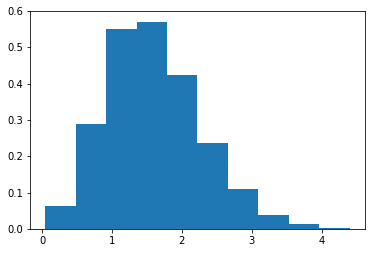

In [30]:
fig,ax = plt.subplots()
ax.hist(mxwell.rvs(size=10000),normed=True)
plt.show()

## 2.2 Modelling scattering

In [31]:
def rand_sign(size):
    return np.array([np.random.choice((-1,1)) for i in range(size)])

In [32]:
def P_scattering(dt):
    return 1 - np.exp(-dt/tau_mn)

In [59]:
def run_avg(val,n):
    return ((val*(n-1)) + val)/n

In [35]:

mxwl_vel_x = therm_v * mxwell.rvs(size=num_particles)
mxwl_vel_y = therm_v * mxwell.rvs(size=num_particles)
info2 = np.array([x,y,mxwl_vel_x,mxwl_vel_y])

In [178]:
fig3 = figure(width=500,height = 500,x_range=[0,200e-9],y_range = [0,100e-9],webgl=True)
plot3 = fig3.multi_line(x,y,line_color=colors)
handle3 = show(fig3,notebook_handle=True)

In [179]:
fig4 = figure(width=500,height = 100,webgl=True)
plot4 = fig4.line([0],[0])
handle4 = show(fig4,notebook_handle=True)

In [174]:


def maxwell_particles(iterations,info,particle_plot,particle_handle,temp_plot,temp_handle):
    num_dots = len(info[0]) # assume second dimension holds the particles
    old_x = np.array(particle_plot.data_source.data['xs'])
    old_y = np.array(particle_plot.data_source.data['ys'])
    
    avg_vel = 0
    avg_scattering = 0
    scatter_vec = np.zeros((num_dots))
    for t in range(iterations):
        time = 1e-14

        # part 2.2 Scattering with Maxwell Boltzmann rethermalization

        rand_mask = np.random.rand(num_dots)
        mask = P_scattering(time) > rand_mask
        num_positives = len(info[2,mask])
        info[2,mask] = maxwell().rvs(size=num_positives)*therm_v
        
        scatter_vec[mask] = t - scatter_vec[mask] #collect mean time between collision
        
        rand_mask = np.random.rand(num_dots)
        mask = P_scattering(time) > rand_mask
        num_positives = len(info[3,mask])
        info[3,mask] = maxwell().rvs(size=num_positives)*therm_v


        #take the norm of the x and y velocities
        avg_vel = np.sqrt(np.mean(info[2,:])**2 + np.mean(info[2,:])**2)
        plot_update(t,avg_vel,temp_handle,temp_plot)




        calc_x = old_x[:] + (info[2,:]*time)
        calc_y = old_y[:] + (info[3,:]*time)

        # reflects the particle if it hits top or bottom
        info[3,:]= np.where(calc_y < 0,-1*info[3,:],info[3,:]) # invert the Y velocities if out of bounds (bottom)
        info[3,:]= np.where(calc_y >= region[1],-1*info[3,:],info[3,:]) # invert Y velocity if out of bounds (top)

        #clip values 
        calc_y = calc_y.clip(0,region[1])

        calc_x = calc_x % region[0]


        new_x = np.expand_dims(calc_x,-1)
        new_y = np.expand_dims(calc_y,-1)


        bokeh_update(new_x,new_y,particle_handle, particle_plot)

        old_x = calc_x
        old_y = calc_y
    return np.mean(scatter_vec)

### 2.3

The temperature is randomly oscillates around the 300,000 m/s average thermal velocity

### 2.4

In [180]:
maxwell_particles(100,info2,plot3,handle3,plot4,handle4)

45.130000000000003

The mean collision time is 45.13e-14 or 0.45ps, from the graph the average thermal velocity is around 300,000 m/s. The mean free path is 135nm

## Part 3

In [160]:
num_particles = 10000
mxwl_x,mxwl_y = spawn_particles(num_particles)

mxwl_vel_x = therm_v * mxwell.rvs(size=num_particles)
mxwl_vel_y = therm_v * mxwell.rvs(size=num_particles)
info3 = np.array([mxwl_x,mxwl_y,mxwl_vel_x,mxwl_vel_y])


In [161]:
def spawn_particles(n):
    x = []
    y = []
    #get spawnable zones
    for i in range(n):
        r_y = np.random.randint(0,100)*1e-9
        if np.random.rand() > 0.5:
            r_x = np.random.randint(0,60)*1e-9
            
        else:
            r_x = np.random.randint(140,200)*1e-9
        x.append(r_x)
        y.append(r_y)
    return x,y

In [175]:
fig5 = figure(width=500,height = 500,x_range=[0,200e-9],y_range = [0,100e-9],webgl=True)
fig5.rect(x=[100e-9,100e-9], y=[20e-9,80e-9], width=40e-9, height=40e-9, color="#CAB2D6",
       angle=0, )
plot5 = fig5.multi_line(mxwl_x,mxwl_y,line_color=colors)

handle5 = show(fig5,notebook_handle=True)

C:\SPB_Data\.conda\envs\4700\lib\site-packages\bokeh\models\sources.py:81: BokehUserWarning: ColumnDataSource's columns must be of the same length
  lambda: warnings.warn("ColumnDataSource's columns must be of the same length", BokehUserWarning))


In [176]:
fig6 = figure(width=500,height = 100,webgl=True)
plot6 = fig6.line([0],[0])
handle6 = show(fig6,notebook_handle=True)

In [177]:
maxwell_particles(200,info3,plot5,handle5,plot6,handle6)

C:\SPB_Data\.conda\envs\4700\lib\site-packages\bokeh\models\sources.py:81: BokehUserWarning: ColumnDataSource's columns must be of the same length
  lambda: warnings.warn("ColumnDataSource's columns must be of the same length", BokehUserWarning))
C:\SPB_Data\.conda\envs\4700\lib\site-packages\bokeh\models\sources.py:81: BokehUserWarning: ColumnDataSource's columns must be of the same length
  lambda: warnings.warn("ColumnDataSource's columns must be of the same length", BokehUserWarning))


KeyboardInterrupt: 

In [88]:
info3.shape

(4,)

In [72]:
plot5.data_source.data.keys()

dict_keys(['line_color', 'xs', 'ys'])

In [70]:
maxwell().rvs(1)

array([ 1.97604691])

In [71]:
info[2,0]

115754.59179226481

In [73]:
P_scattering(1e-14)

0.048770575499285984

In [74]:
info[2,:]

array([ 115754.59179226,   91461.36647844,   73113.41806433,
        126242.6592556 ,    5384.86356336,   45406.47115136,
        124014.26525096,   59149.65082573,  120307.14775104,
         90688.44524382])

In [75]:
np.where(P_scattering(1e-14) > np.random.rand(),1,0)

array(0)

In [77]:
tmp = np.random.rand(num_particles)
tmp

array([ 0.56810542,  0.72685796,  0.96679689,  0.65960585,  0.97449359,
        0.10708453,  0.15818961,  0.37989645,  0.15890266,  0.5064911 ])

In [79]:
mask = tmp > P_scattering(1e-14)
mask

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,  True], dtype=bool)

In [113]:
def rand_sign(size):
    return [np.random.choice((-1,1)) for i in range(size)]

b = np.random.random(5)
b

array([ 0.51224674,  0.42667805,  0.37835387,  0.59302718,  0.14190249])

In [134]:
info[2,:]


array([ 370294.09394874,  311854.31436009,   48758.17209586,
        271276.67112382,   79743.72794611,  143626.67152747,
        233396.03322843,   93276.11959607,  368465.49601233,
        155417.17146505])

In [151]:
rand_mask = np.random.rand(num_particles)
mask = P_scattering(time) > rand_mask
mask

array([False, False, False, False,  True, False, False, False, False, False], dtype=bool)

In [149]:
len(mask == False)

10

In [138]:
mask

array([False, False, False, False, False, False,  True, False, False, False], dtype=bool)

In [153]:
marr = np.ma.masked_array(info[2,:],mask)

In [154]:
info[2,:]

array([ 370294.09394874,  311854.31436009,   48758.17209586,
        271276.67112382,   79743.72794611,  143626.67152747,
        233396.03322843,   93276.11959607,  368465.49601233,
        155417.17146505])

In [57]:
tmp = np.random.randint(0,100,200)
np.mean(tmp)

46.039999999999999

In [49]:
mean = 1/1
mean

1.0

In [51]:
(1*1 + 2)/2

1.5

In [52]:
(1.5*2 + 3)/3

2.0

In [53]:
np.mean([1,2,3])

2.0

In [58]:
mean = 0
for i,val in enumerate(tmp):
    cnt = i+1
    mean = ((mean*(cnt-1)) + val)/cnt
mean

46.04000000000002